In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.python.util import compat
from tensorflow.core.protobuf import saved_model_pb2
from google.protobuf import text_format
import pprint
import json
import os
import time

In [16]:
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import dataset_util, label_map_util
from object_detection.protos import string_int_label_map_pb2

In [17]:
def reconstruct(pb_path):
    if not os.path.isfile(pb_path):
        print("Error: %s not found" % pb_path)

    print("Reconstructing Tensorflow model")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(pb_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    print("Success!")
    return detection_graph

In [18]:
def categorize_waste(category):
    dry_waste = ["Aluminium foil", "Battery", "Aluminium blister pack", "Carded blister pack", "Other plastic bottle",
                 "Broken glass", "Food Can", "Aerosol", "Toilet tube", "Other carton", "Egg carton", "Pizza box",
                 "Garbage bag", "Crisp packet", "Spread tub", "Tupperware", "Disposable food container", 
                 "Foam food container", "Other plastic container", "Plastic gloves", "Plastic utensils", 
                 "Rope & strings", "Shoe", "Styrofoam piece", "Unlabeled litter", "Cigarette", "Disposable plastic cup", 
                 "Foam cup", "Glass cup", "Other plastic cup"]

    wet_waste = ["Food waste"]

    recyclable_waste = ["Clear plastic bottle", "Glass bottle", "Plastic bottle cap", "Metal bottle cap", 
                        "Drink can", "Drink carton", "Corrugated carton", "Meal carton", "Magazine paper", 
                        "Wrapping paper", "Normal paper", "Paper bag", "Plastified paper bag", "Plastic film", 
                        "Six pack rings", "Other plastic wrapper", "Single-use carrier bag", "Polypropylene bag", 
                        "Pop tab", "Scrap metal", "Plastic straw", "Paper straw", "Glass jar", "Plastic lid", 
                        "Metal lid", "Other plastic"]

    non_recyclable_waste = ["Other plastic bottle", "Broken glass", "Food Can", "Toilet tube", "Egg carton", 
                            "Other carton", "Disposable plastic cup", "Other plastic cup", "Styrofoam piece", 
                            "Unlabeled litter", "Cigarette"]

    e_waste = ["Battery"]

    biodegradable_waste = ["Food waste"]
    
    waste_types = []


    if category in dry_waste:
        waste_types.append("Dry")
    if category in wet_waste:
        waste_types.append("Wet")
    if category in recyclable_waste:
        waste_types.append("Dry, Recyclable")
    if category in non_recyclable_waste:
        waste_types.append("Non-Recyclable")
    if category in e_waste:
        waste_types.append("E-Waste")
    if category in biodegradable_waste:
        waste_types.append("Wet, Biodegradable")
    return waste_types
def image2np(image):
    (w, h) = image.size
    return np.array(image.getdata()).reshape((h, w, 3)).astype(np.uint8)

def image2tensor(image):
    npim = image2np(image)
    return np.expand_dims(npim, axis=0)
waste_ty = ""
%matplotlib inline
def detect(detection_graph, test_image_path):
    with detection_graph.as_default():
        gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.01)
        with tf.compat.v1.Session(graph=detection_graph,config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            image = Image.open(test_image_path)
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image2tensor(image)}
            )

            npim = image2np(image)
            vis_util.visualize_boxes_and_labels_on_image_array(
                npim,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=15)

            for i in range(len(boxes)):
                for j, score in enumerate(scores[i]):
                    if score > 0.5:
                        ymin, xmin, ymax, xmax = boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]
                        class_index = int(classes[i][j])
                        class_name = category_index[class_index]['name']
                        waste_types = categorize_waste(class_name)
                        global waste_ty
                        for item in waste_types:
                               waste_ty += item + ' '
                        print(f'\nBounding box {j+1}: \nLabel={class_name}\n Score={score:.2f} ')
                        print("Waste types:", waste_types)

            plt.figure(figsize=(12, 8))
            plt.imshow(npim)
            plt.show()

In [19]:
DATA_DIR = './tacotrashdataset/data'
ANNOTATIONS_FILE = os.path.join(DATA_DIR, 'annotations.json')
NCLASSES = 60

In [20]:
with open(ANNOTATIONS_FILE) as json_file:
    data = json.load(json_file)

categories = data['categories']

In [21]:
print('Building label map from examples')

labelmap = string_int_label_map_pb2.StringIntLabelMap()
for idx,category in enumerate(categories):
    item = labelmap.item.add()
    item.id = int(category['id'])+1
    item.name = category['name']
with open('./labelmap.pbtxt', 'w') as f:
    f.write(text_format.MessageToString(labelmap))

print('Label map witten to labelmap.pbtxt')

with open('./labelmap.pbtxt') as f:
    pprint.pprint(f.readlines())

Building label map from examples
Label map witten to labelmap.pbtxt
['item {\n',
 '  name: "Aluminium foil"\n',
 '  id: 1\n',
 '}\n',
 'item {\n',
 '  name: "Battery"\n',
 '  id: 2\n',
 '}\n',
 'item {\n',
 '  name: "Aluminium blister pack"\n',
 '  id: 3\n',
 '}\n',
 'item {\n',
 '  name: "Carded blister pack"\n',
 '  id: 4\n',
 '}\n',
 'item {\n',
 '  name: "Other plastic bottle"\n',
 '  id: 5\n',
 '}\n',
 'item {\n',
 '  name: "Clear plastic bottle"\n',
 '  id: 6\n',
 '}\n',
 'item {\n',
 '  name: "Glass bottle"\n',
 '  id: 7\n',
 '}\n',
 'item {\n',
 '  name: "Plastic bottle cap"\n',
 '  id: 8\n',
 '}\n',
 'item {\n',
 '  name: "Metal bottle cap"\n',
 '  id: 9\n',
 '}\n',
 'item {\n',
 '  name: "Broken glass"\n',
 '  id: 10\n',
 '}\n',
 'item {\n',
 '  name: "Food Can"\n',
 '  id: 11\n',
 '}\n',
 'item {\n',
 '  name: "Aerosol"\n',
 '  id: 12\n',
 '}\n',
 'item {\n',
 '  name: "Drink can"\n',
 '  id: 13\n',
 '}\n',
 'item {\n',
 '  name: "Toilet tube"\n',
 '  id: 14\n',
 '}\n',
 'it

In [22]:
label_map = label_map_util.load_labelmap('labelmap.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NCLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [23]:
detection_graph = reconstruct("./trained-models-taco-trash-annotations-in-context/ssd_mobilenet_v2_taco_2018_03_29.pb")

Reconstructing Tensorflow model
Success!


In [24]:
def delete_other_images(folder_path, latest_image_path):
  
  if not os.path.exists(latest_image_path):
    print(f"Error: Latest image '{latest_image_path}' not found.")
    return

  for filename in os.listdir(folder_path):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")) and filename != os.path.basename(latest_image_path):
      file_path = os.path.join(folder_path, filename)
      try:
        os.remove(file_path)
        print(f"Deleted image: {filename}")
      except OSError as e:
        print(f"Error deleting {filename}: {e}")

In [25]:
import serial.tools.list_ports

ports = serial.tools.list_ports.comports()
serialInst = serial.Serial()
portsList = []

for one in ports:
    portsList.append(str(one))
    print(str(one))
    
com = 10

serialInst.baudrate = 9600
serialInst.port = "COM6"
serialInst.open()
command = "HELLO"
serialInst.write(command.encode('utf-8'))


COM6 - USB-SERIAL CH340 (COM6)
COM10 - USB-SERIAL CH340 (COM10)
COM11 - SAMSUNG Mobile USB Modem


5

In [26]:
def is_truncated(image_path):
  """Checks if an image is truncated using PIL."""
  try:
    with Image.open(image_path) as img:
      img.load()  # Load the image without conversion for checking
      return False  # Image loaded successfully, not truncated
  except (OSError, IOError) as e:
    if "truncated" in str(e):
      return True
    else:
      raise

In [27]:
def get_image_paths(folder_path):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']  # Add more extensions if needed
    image_paths = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_paths.append(os.path.join(root, file))

    return image_paths


./IMAGES\IMG_6254.JPG
Original image size: 3024x4032

Bounding box 1: 
Label=Drink can
 Score=0.89 
Waste types: ['Dry, Recyclable']

Bounding box 2: 
Label=Plastic bottle cap
 Score=0.19 
Waste types: ['Dry, Recyclable']


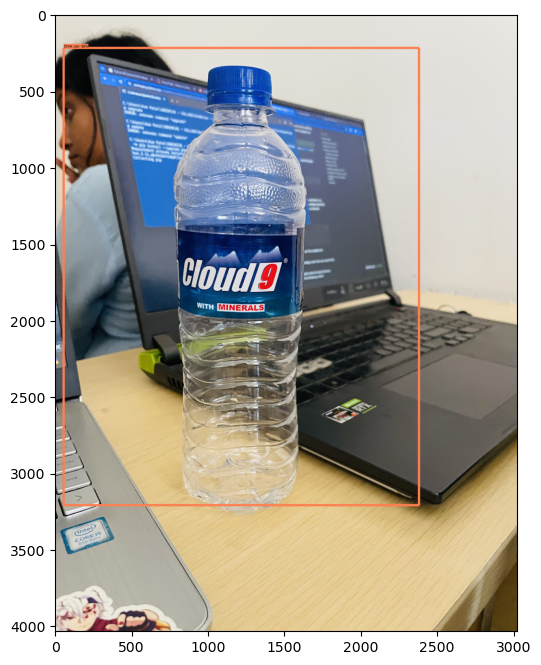

Dry, Recyclable Dry, Recyclable 
./IMAGES\IMG_6266.JPG
Original image size: 3024x4032

Bounding box 1: 
Label=Drink can
 Score=0.73 
Waste types: ['Dry, Recyclable']

Bounding box 2: 
Label=Crisp packet
 Score=0.44 
Waste types: ['Dry']

Bounding box 3: 
Label=Drink carton
 Score=0.13 
Waste types: ['Dry, Recyclable']


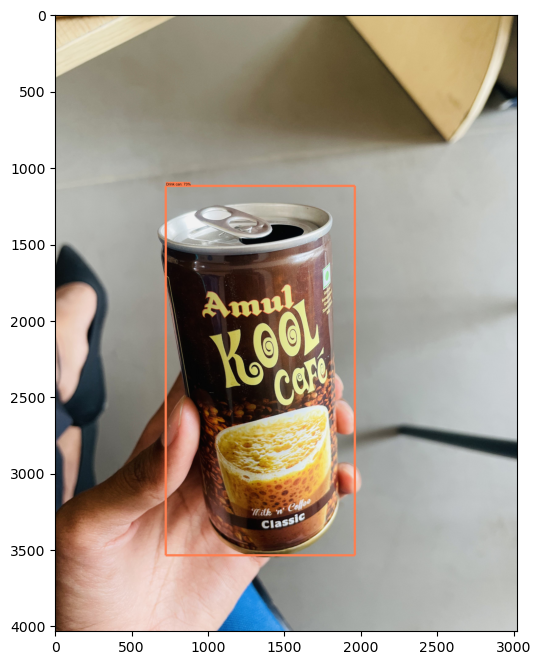

Dry, Recyclable Dry Dry, Recyclable 
./IMAGES\IMG_6267.JPG
Original image size: 3024x4032

Bounding box 1: 
Label=Clear plastic bottle
 Score=0.92 
Waste types: ['Dry, Recyclable']

Bounding box 2: 
Label=Plastic film
 Score=0.44 
Waste types: ['Dry, Recyclable']

Bounding box 3: 
Label=Plastic bottle cap
 Score=0.23 
Waste types: ['Dry, Recyclable']


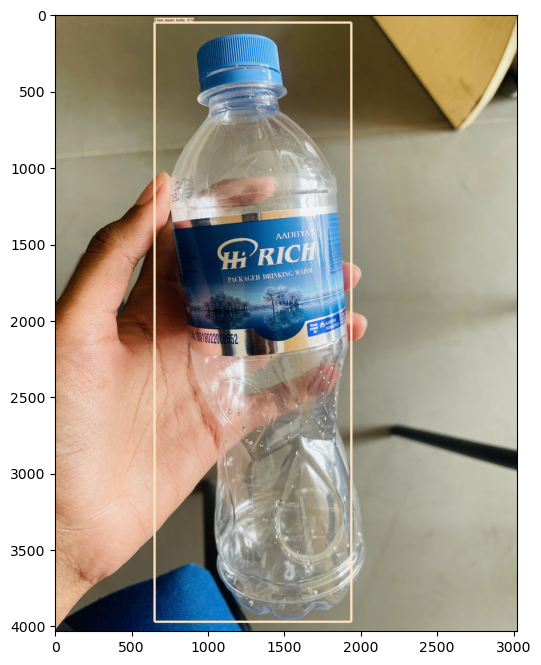

Dry, Recyclable Dry, Recyclable Dry, Recyclable 
./IMAGES\IMG_6268.JPG
Original image size: 3024x4032

Bounding box 1: 
Label=Tupperware
 Score=0.45 
Waste types: ['Dry']

Bounding box 2: 
Label=Corrugated carton
 Score=0.39 
Waste types: ['Dry, Recyclable']

Bounding box 3: 
Label=Spread tub
 Score=0.33 
Waste types: ['Dry']

Bounding box 4: 
Label=Corrugated carton
 Score=0.20 
Waste types: ['Dry, Recyclable']

Bounding box 5: 
Label=Foam cup
 Score=0.18 
Waste types: ['Dry']


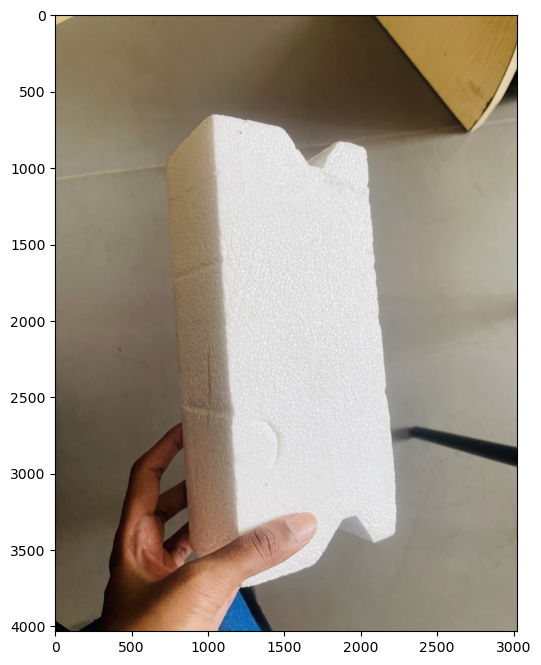

Dry Dry, Recyclable Dry Dry, Recyclable Dry 
./IMAGES\IMG_6269.JPG
Original image size: 3024x4032

Bounding box 1: 
Label=Garbage bag
 Score=0.52 
Waste types: ['Dry']

Bounding box 2: 
Label=Single-use carrier bag
 Score=0.31 
Waste types: ['Dry, Recyclable']


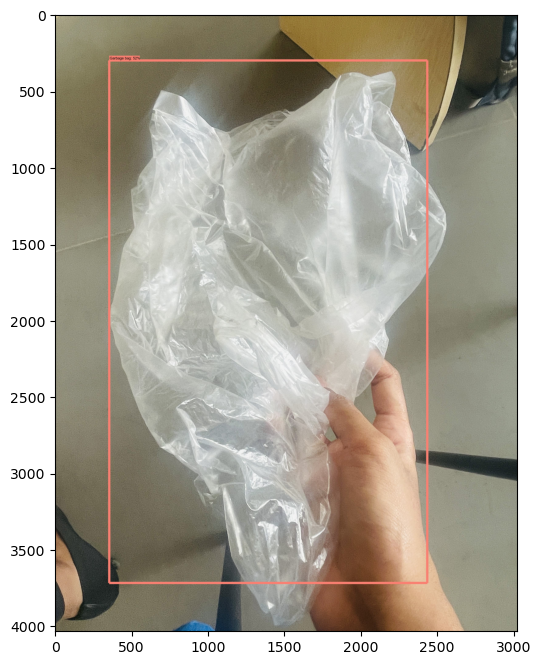

Dry Dry, Recyclable 


In [14]:
import time
import os
folder_path = './IMAGES'


#delete_other_images(folder_path, latest_image)
image_paths = get_image_paths(folder_path)

for image_path in image_paths:
    print(image_path)
    latest_image = image_path
    image = Image.open(latest_image)
    width, height = image.size
    print(f"Original image size: {width}x{height}")
    channels = len(image.mode)  # Get number of channels from image mode
    image = Image.open(latest_image)
    image = image.convert('RGB')
    new_image_path = "./updated_images/updated_image.jpg"  # Replace with desired path
    image.save(new_image_path)
    detect(detection_graph, new_image_path)
    delete_other_images('./updated_images', new_image_path)
    print(waste_ty)
    command = waste_ty
    serialInst.write(command.encode('utf-8'))
    waste_ty = ""
    if command == 'exit':
        exit()
time.sleep(10)